In [17]:
import sys
import os
from typing import List, Dict, Tuple, Any

eval_folder_path = "exp/FedAvg_sasrec_on_sr_data_lr0.001_lstep5/random_augmented_5e-1"
print_log_path = os.path.join(eval_folder_path, "exp_print.log")
evaluation_log_path = os.path.join(eval_folder_path, "eval_results.log")


In [18]:
def load_log_file(file_path : str) -> str:
    """
    Load the log file and return the content as string.
    """
    with open(file_path, 'r') as file:
        log_content = file.read()
    
    return log_content

In [19]:

log_content = load_log_file(print_log_path)

In [20]:
## Federated Learning Infos
import ast

federated_configuration = {}

federated_configuration["client_num"] = ast.literal_eval(log_content.split('client_num: ')[1].split('\n')[0]) ## To int
federated_configuration["attacker_id"] = ast.literal_eval(log_content.split('attacker_id: ')[1].split('\n')[0]) ## To list
federated_configuration["total_round_num"] = ast.literal_eval(log_content.split('total_round_num: ')[1].split('\n')[0]) ## To int
federated_configuration["sample_client_num"] = ast.literal_eval(log_content.split('sample_client_num: ')[1].split('\n')[0]) ## To int
federated_configuration["local_update_steps"] = ast.literal_eval(log_content.split('local_update_steps: ')[2].split('\n')[0]) ## To int

print(federated_configuration)

{'client_num': 6290, 'attacker_id': [6041, 6042, 6043, 6044, 6045, 6046, 6047, 6048, 6049, 6050, 6051, 6052, 6053, 6054, 6055, 6056, 6057, 6058, 6059, 6060, 6061, 6062, 6063, 6064, 6065, 6066, 6067, 6068, 6069, 6070, 6071, 6072, 6073, 6074, 6075, 6076, 6077, 6078, 6079, 6080, 6081, 6082, 6083, 6084, 6085, 6086, 6087, 6088, 6089, 6090, 6091, 6092, 6093, 6094, 6095, 6096, 6097, 6098, 6099, 6100, 6101, 6102, 6103, 6104, 6105, 6106, 6107, 6108, 6109, 6110, 6111, 6112, 6113, 6114, 6115, 6116, 6117, 6118, 6119, 6120, 6121, 6122, 6123, 6124, 6125, 6126, 6127, 6128, 6129, 6130, 6131, 6132, 6133, 6134, 6135, 6136, 6137, 6138, 6139, 6140, 6141, 6142, 6143, 6144, 6145, 6146, 6147, 6148, 6149, 6150, 6151, 6152, 6153, 6154, 6155, 6156, 6157, 6158, 6159, 6160, 6161, 6162, 6163, 6164, 6165, 6166, 6167, 6168, 6169, 6170, 6171, 6172, 6173, 6174, 6175, 6176, 6177, 6178, 6179, 6180, 6181, 6182, 6183, 6184, 6185, 6186, 6187, 6188, 6189, 6190, 6191, 6192, 6193, 6194, 6195, 6196, 6197, 6198, 6199, 6200, 620

In [21]:
import ast
import re

#local_results = log_content.split('(client:354)')[1:]

## if key the line has '(client:354)' or '(sr_sybil_attack_server:560)' then that line is a hit
local_train_report = []
for line in log_content.split('\n') :
    if '(client:354)' in line or '(sr_sybil_attack_server:579)' in line :
        local_train_report.append(line)

#sprint(len(local_train_report))
#print(local_train_report[0])
## Split content by 'INFO: ' and convert to dictionary
refined_local_results = []

for local_result in local_train_report :
    refined_str = local_result.split('INFO: ')[1]
    refined_dict = ast.literal_eval(refined_str)
    refined_local_results.append(refined_dict)

print(len(refined_local_results))
print(refined_local_results[0]['Round'])



23262
0


In [22]:
## segregate attacker and non-attacker clients

benign_clients_result = []
malicious_clients_result = []

def parse_client_id(role : str) -> int :
    """
    Parse the client id from the role string such as 'Client #593'.
    """
    return int(role.split('#')[1])

for line_num, local_result in enumerate(refined_local_results):
    current_id = parse_client_id(local_result['Role'])
    
    if current_id in federated_configuration["attacker_id"]:
        #print(f"{line_num},{current_id}")
        malicious_clients_result.append(local_result)
    else:
        benign_clients_result.append(local_result)

print(len(malicious_clients_result))
print(len(benign_clients_result))


4
23258


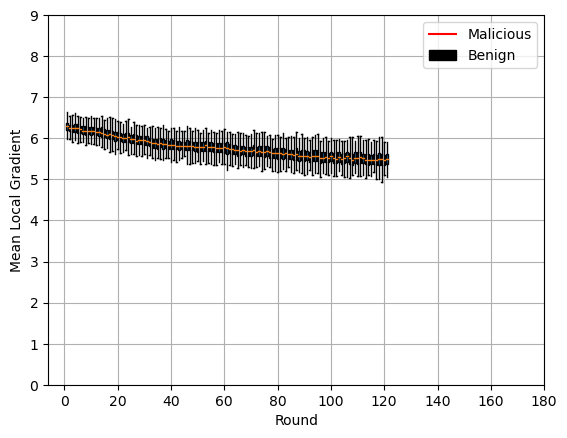

In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

## x-axis : round, y-axis : loss mean, std, max, min

## for each round loss values are
benign_gradients = {i : [] for i in range(federated_configuration["total_round_num"])}
malicious_gradients = {i : [] for i in range(federated_configuration["total_round_num"])}

for local_result in benign_clients_result:
    current_round = local_result['Round']
    benign_gradients[current_round].append(local_result['Results_raw']['train_avg_loss'])
    
for local_result in malicious_clients_result:
    current_round = local_result['Round']
    malicious_gradients[current_round].append(local_result['Results_raw']['train_avg_loss'])

benign_datas = [value for key, value in benign_gradients.items()]

fig, ax = plt.subplots()

benign_boxplot = ax.boxplot(benign_datas, showfliers=False, patch_artist=True, vert=True, labels=benign_gradients.keys(), manage_ticks=False)


mean_malicious_gradients = np.zeros((federated_configuration["total_round_num"]))
for round, gradients in malicious_gradients.items():
    if len(gradients) == 0:
        mean_malicious_gradients[round] = np.nan
    else: 
        mean_malicious_gradients[round] = np.mean(gradients)

malicious_line_plot = ax.plot(mean_malicious_gradients, label='Malicious', color='red')

plt.xlabel('Round')
ax.set_xticks(np.arange(0, federated_configuration["total_round_num"], 20))
ax.grid(True)
plt.ylabel('Mean Local Gradient')

handles, labels = ax.get_legend_handles_labels()
empty_boxplot_label = mpatches.Patch(color='black', label='Benign')
handles.extend([empty_boxplot_label]) 
ax.legend(handles=handles)
ax.set_ylim(0, 9)

plt.show()





In [24]:
import numpy as np

## Sample random 250 client ids from all 6040 users. 
## 1 ~ 6040

random_ids = np.random.randint(1, 6040, 250)
random_ids = np.sort(random_ids)

result_string = "["
for client_id in random_ids:
    result_string += str(client_id) + ", "

result_string = result_string[:-2] + "]"    

print(result_string)

[16, 45, 64, 79, 92, 94, 97, 99, 111, 134, 170, 216, 219, 224, 226, 228, 233, 237, 366, 370, 370, 424, 531, 551, 583, 587, 599, 609, 643, 662, 676, 789, 810, 819, 863, 865, 875, 881, 891, 906, 906, 923, 939, 1027, 1030, 1052, 1131, 1150, 1186, 1223, 1236, 1237, 1241, 1252, 1259, 1260, 1263, 1275, 1305, 1338, 1340, 1346, 1354, 1373, 1463, 1478, 1480, 1484, 1492, 1500, 1515, 1544, 1565, 1592, 1598, 1625, 1667, 1755, 1773, 1811, 1828, 1837, 1839, 1851, 1853, 1908, 1930, 1967, 1968, 1999, 2026, 2034, 2043, 2045, 2125, 2165, 2210, 2224, 2232, 2241, 2275, 2303, 2303, 2360, 2397, 2415, 2415, 2426, 2428, 2453, 2461, 2479, 2484, 2491, 2499, 2523, 2566, 2572, 2615, 2640, 2668, 2714, 2735, 2757, 2757, 2806, 2853, 2880, 2891, 2938, 2988, 3020, 3088, 3094, 3139, 3144, 3201, 3207, 3211, 3224, 3226, 3228, 3270, 3341, 3379, 3381, 3404, 3455, 3477, 3502, 3512, 3531, 3535, 3536, 3549, 3580, 3630, 3633, 3638, 3646, 3647, 3661, 3681, 3689, 3720, 3728, 3805, 3808, 3811, 3827, 3836, 3860, 3873, 3900, 3963, 